In [167]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import simps

%matplotlib inline

In [152]:
inputfile = '../input_bpass_z002_sin_imf135_300'
masses = []
weights = []
f = open(inputfile,'r')
tot_imf = f.readline()
while True:
    filename = f.readline()
    if not filename:
        break
    mass = filename.split('-')[-1]
    masses.append(float(mass))
    imf_line = f.readline()
    imf_weight = imf_line.split()[0]
    weights.append(float(imf_weight))
f.close()
masses = np.flip(masses)
weights = np.flip(weights)

The IMF looks like:

$\Phi(M) = AM^{-\alpha}$

If the slope changes at $M_*$ from $\alpha_1$ (low mass slope) to $\alpha_2$ (high mass slope), we require the IMF the yield the same value given both slopes, requiring two different normalizations. If we know the high mass slope (e.g., Salpeter 2.35 IMF) and normalization:

$A_1M_*^{-\alpha_1} = A_2M_*^{-\alpha_2}$

$A_1 = A_2 M_*^{\alpha_1 - \alpha_2}$

In [197]:
def IMF(mass,hi_mass_normalization=1.0,lo_mass_slope=1.3,hi_mass_slope=2.35,m_star=0.5,lo_mass_cut=0.1,hi_mass_cut=300.0):
    lo_mass_normalization = hi_mass_normalization*m_star**(lo_mass_slope-hi_mass_slope)
    if hasattr(mass,'__len__'):
        out = []
        for m in mass:
            if (m < lo_mass_cut) or (m > hi_mass_cut):
                out.append(0)
            elif (m <= m_star):
                out.append(lo_mass_normalization*m**-lo_mass_slope)
            else:
                out.append(hi_mass_normalization*m**-hi_mass_slope)
        return out
    else:
        if (mass < lo_mass_cut) or (mass > hi_mass_cut):
            return 0
        elif (mass <= m_star):
            return lo_mass_normalization*mass**-lo_mass_slope
        else:
            return hi_mass_normalization*mass**-hi_mass_slope

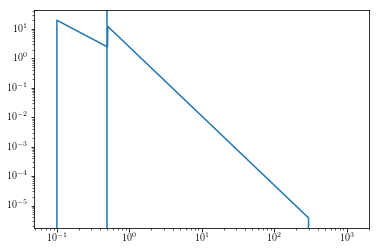

In [181]:
#is the function working correctly?
test_masses = np.logspace(-1.1,3.1,1000)
test_imf = IMF(test_masses)
plt.loglog(test_masses, test_imf)
plt.axvline(x=0.5)

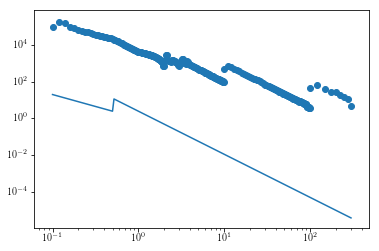

In [182]:
#are the weights just the raw IMF? (no)
plt.loglog(masses,IMF(masses))
plt.scatter(masses,weights)

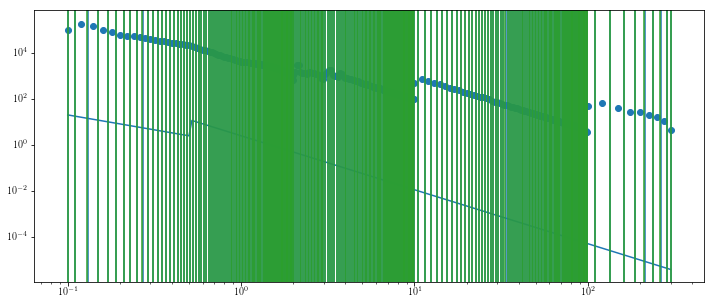

In [183]:
fig = plt.figure(figsize=(12,5))
linear_bin_edges = [masses[0]]
log_bin_edges = [masses[0]]
for i,m in enumerate(masses):
    if i == 0:
        pass
    else:
        average = 0.5*(masses[i-1] + m)
        linear_bin_edges.append(average)
        logarithmic_average = np.power(masses[i-1]*m,0.5)
        log_bin_edges.append(logarithmic_average)
        
linear_bin_edges.append(300.0)
log_bin_edges.append(300.0)
linear_bin_edges = np.array(linear_bin_edges)
log_bin_edges = np.array(log_bin_edges)
plt.loglog(masses,IMF(masses))
plt.scatter(masses,weights)
for e in linear_bin_edges:
    plt.axvline(x=e)
for e in log_bin_edges:
    plt.axvline(x=e,c='C2')

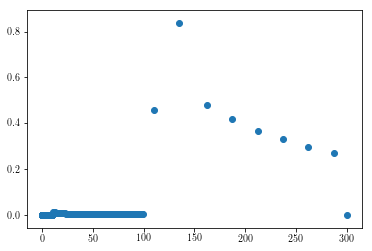

In [184]:
plt.scatter(linear_bin_edges,np.abs(log_bin_edges-linear_bin_edges))

First let's figure out the total number of stars formed. In BPASS, that's just the sum of the weights, $N_*$. For our IMF, with lower limit $M_l$, upper limit $M_u$, and threshold mass $M_*$, that's going to be the integral

$N = \int_{M_l}^{M_u}\Phi(M)dM = \int_{0.1}^{M_*}A_1M^{-\alpha_1}dM + \int_{M_*}^{M_u}A_2M^{-\alpha_2}dM$

We can substitute in for the lower mass normalization:

$N = \int_{0.1}^{M_*}A_2M_*^{\alpha_1-\alpha_2}M^{-\alpha_1}dM + \int_{M_*}^{M_u}A_2M^{-\alpha_2}dM$

Solving directly:

$N = A_2 \bigg[\frac{M_*^{\alpha_1-\alpha_2}M^{1-\alpha_1}}{1-\alpha_1}\Big|_{M_l}^{M_*} + \frac{M^{1-\alpha_2}}{1-\alpha_2}\Big|_{M_*}^{M_u}\bigg]$ 

$N = A_2\bigg[\frac{M_*^{1-\alpha_2}-M_*^{\alpha_1-\alpha_2}M_l^{1-\alpha_1}}{1-\alpha_1}+ \frac{M_u^{1-\alpha_2}-M_*^{1-\alpha_2}}{1-\alpha_2}\bigg]$

So, if we want the weights to work out identically, we can set $N=N_*$, so

$A_2 = \frac{N_*}{\frac{M_*^{1-\alpha_2}-M_*^{\alpha_1-\alpha_2}M_l^{1-\alpha_1}}{1-\alpha_1}+ \frac{M_u^{1-\alpha_2}-M_*^{1-\alpha_2}}{1-\alpha_2}}$

In [198]:
#writing a function to implement this
def IMF_known_stars(mass,N_stars=1.0,lo_mass_slope=1.3,hi_mass_slope=2.35,m_star=0.5,lo_mass_cut=0.1,hi_mass_cut=300.0):
    
    numerator = N_stars
    
    denom1_num = np.power(m_star,1.0-hi_mass_slope)-np.power(m_star,lo_mass_slope-hi_mass_slope)*np.power(lo_mass_cut,1.0-lo_mass_slope)
    denom1_den = 1.0 - lo_mass_slope
    denom1 = denom1_num/denom1_den
    
    denom2_num = np.power(hi_mass_cut,1.0-hi_mass_slope) - np.power(m_star,1.0-hi_mass_slope)
    denom2_den = 1.0-hi_mass_slope
    denom2 = denom2_num/denom2_den
    
    denomenator = denom1 + denom2
    
    hi_mass_normalization = numerator/denomenator

    
    return IMF(mass,hi_mass_normalization=hi_mass_normalization,lo_mass_slope=lo_mass_slope,
              hi_mass_slope=hi_mass_slope,m_star=m_star,lo_mass_cut=lo_mass_cut,hi_mass_cut=hi_mass_cut)

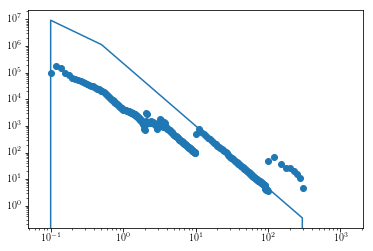

In [199]:
test_masses = np.logspace(-1.1,3.1,1000)
test_imf = IMF_known_stars(test_masses,np.sum(weights))
plt.loglog(test_masses,test_imf)
plt.scatter(masses,weights)

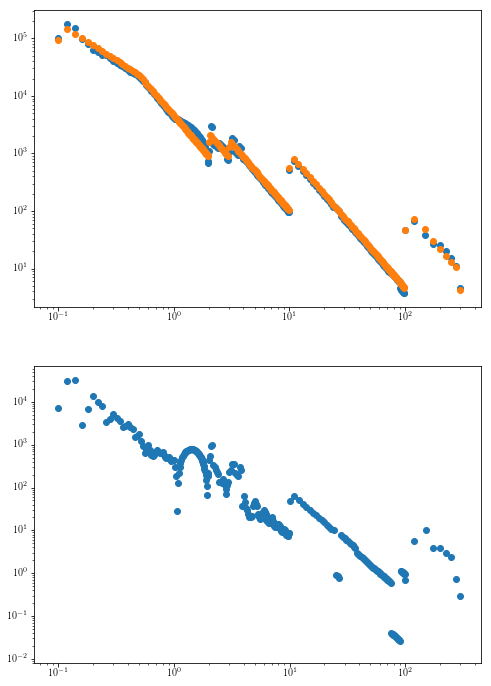

In [200]:
#let's try to replicate the weights!
#First test: for each mass, multiply the IMF by the (linear) bin size
fig, ax = plt.subplots(2,figsize=(8,12))
test_weights = []
for i,m in enumerate(masses):
    imf = IMF_known_stars(m,np.sum(weights))
    bin_size = linear_bin_edges[i+1]-linear_bin_edges[i]
    test_weights.append(imf*bin_size)
ax[0].scatter(masses,weights)
ax[0].scatter(masses,test_weights)
ax[0].set(xscale='log',yscale='log')
ax[1].scatter(masses,np.abs(np.array(test_weights)-np.array(weights)))
ax[1].set(xscale='log',yscale='log');

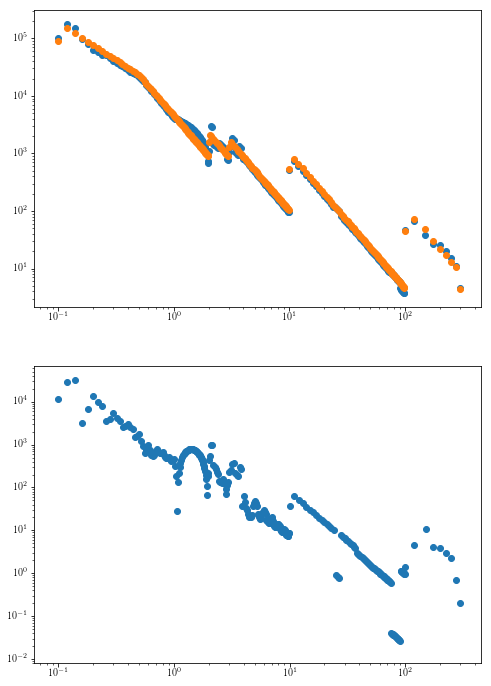

In [201]:
#Ok, so let's try the same thing but with log bin edges
fig, ax = plt.subplots(2,figsize=(8,12))
test_weights = []
for i,m in enumerate(masses):
    imf = IMF_known_stars(m,np.sum(weights))
    bin_size = log_bin_edges[i+1]-log_bin_edges[i]
    test_weights.append(imf*bin_size)
ax[0].scatter(masses,weights)
ax[0].scatter(masses,test_weights)
ax[0].set(xscale='log',yscale='log')
ax[1].scatter(masses,np.abs(np.array(test_weights)-np.array(weights)))
ax[1].set(xscale='log',yscale='log');

In [ ]:
#Let's try calculating the analytic integral in each bin.

def integrate_IMF()

/Users/carina/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


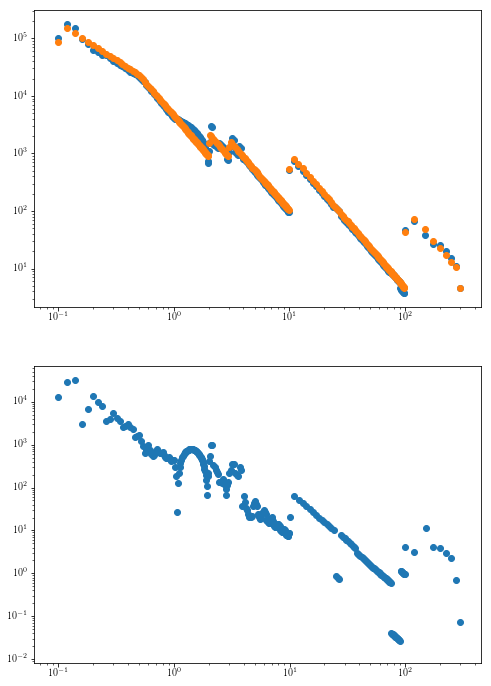

In [203]:
#So let's try something a little complicated. Let's make the weight the integral of the 
#actual IMF, between the linear bin edges
fig, ax = plt.subplots(2,figsize=(8,12))
test_weights = []
for i,m in enumerate(masses):
    imf = IMF_known_stars(m,np.sum(weights))
    bin_lo = linear_bin_edges[i]
    bin_hi = linear_bin_edges[i+1]
    bin_masses = np.linspace(bin_lo,bin_hi,1e4)
    bin_imfs = IMF_known_stars(bin_masses,N_stars=np.sum(weights))
    test_weight = np.trapz(bin_imfs,bin_masses)
    test_weights.append(test_weight)
ax[0].scatter(masses,weights)
ax[0].scatter(masses,test_weights)
ax[0].set(xscale='log',yscale='log')
ax[1].scatter(masses,np.abs(np.array(test_weights)-np.array(weights)))
ax[1].set(xscale='log',yscale='log');

/Users/carina/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


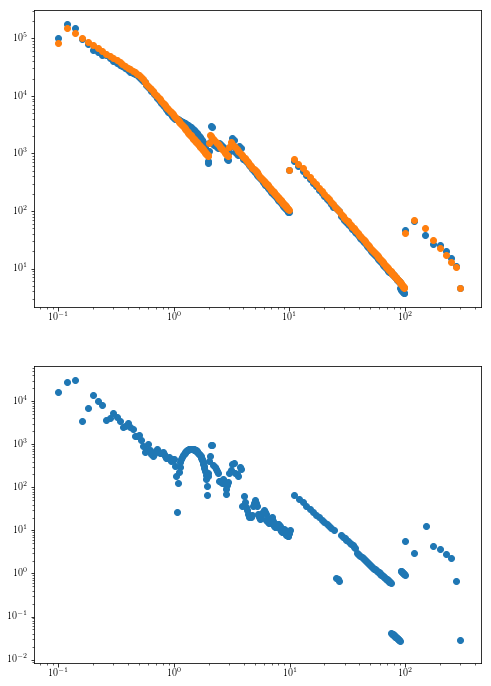

In [204]:
#Same, but with log bin edges
fig, ax = plt.subplots(2,figsize=(8,12))
test_weights = []
for i,m in enumerate(masses):
    imf = IMF_known_stars(m,np.sum(weights))
    bin_lo = log_bin_edges[i]
    bin_hi = log_bin_edges[i+1]
    bin_masses = np.linspace(bin_lo,bin_hi,1e4)
    bin_imfs = IMF_known_stars(bin_masses,N_stars=np.sum(weights))
    test_weight = np.trapz(bin_imfs,bin_masses)
    test_weights.append(test_weight)
ax[0].scatter(masses,weights)
ax[0].scatter(masses,test_weights)
ax[0].set(xscale='log',yscale='log')
ax[1].scatter(masses,np.abs(np.array(test_weights)-np.array(weights)))
ax[1].set(xscale='log',yscale='log');

/Users/carina/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


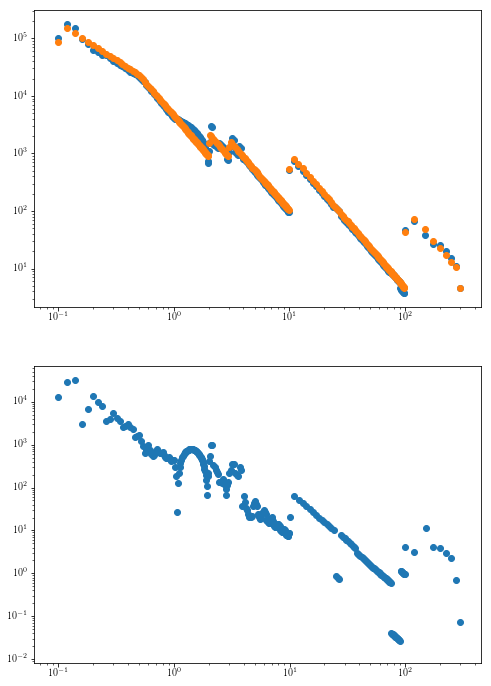

In [205]:
#So let's try something a little complicated. Let's make the weight the integral of the 
#actual IMF, between the linear bin edges. Now use a Simpson's rule integrator
fig, ax = plt.subplots(2,figsize=(8,12))
test_weights = []
for i,m in enumerate(masses):
    imf = IMF_known_stars(m,np.sum(weights))
    bin_lo = linear_bin_edges[i]
    bin_hi = linear_bin_edges[i+1]
    bin_masses = np.linspace(bin_lo,bin_hi,1e4)
    bin_imfs = IMF_known_stars(bin_masses,N_stars=np.sum(weights))
    test_weight = simps(bin_imfs,bin_masses)
    test_weights.append(test_weight)
ax[0].scatter(masses,weights)
ax[0].scatter(masses,test_weights)
ax[0].set(xscale='log',yscale='log')
ax[1].scatter(masses,np.abs(np.array(test_weights)-np.array(weights)))
ax[1].set(xscale='log',yscale='log');

/Users/carina/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


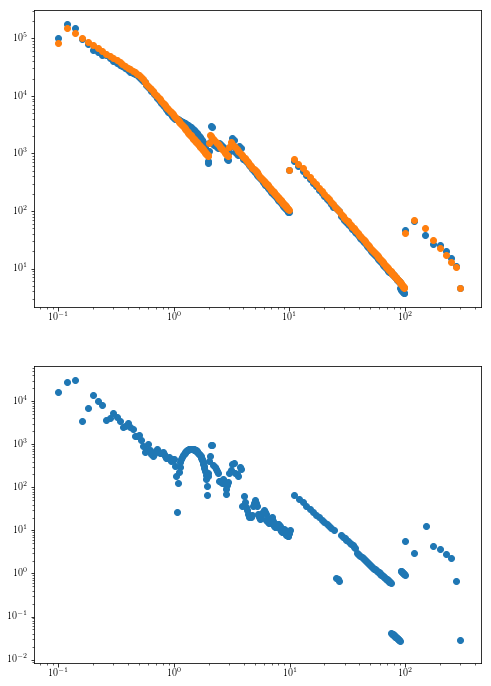

In [206]:
#Same, but with log bin edges
fig, ax = plt.subplots(2,figsize=(8,12))
test_weights = []
for i,m in enumerate(masses):
    imf = IMF_known_stars(m,np.sum(weights))
    bin_lo = log_bin_edges[i]
    bin_hi = log_bin_edges[i+1]
    bin_masses = np.linspace(bin_lo,bin_hi,1e4)
    bin_imfs = IMF_known_stars(bin_masses,N_stars=np.sum(weights))
    test_weight = simps(bin_imfs,bin_masses)
    test_weights.append(test_weight)
ax[0].scatter(masses,weights)
ax[0].scatter(masses,test_weights)
ax[0].set(xscale='log',yscale='log')
ax[1].scatter(masses,np.abs(np.array(test_weights)-np.array(weights)))
ax[1].set(xscale='log',yscale='log');